In [169]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [170]:
ds = xr.open_dataset("../output/grids/a3d_grids.nc")
# ds = xr.open_dataset("../../a3d_grids.nc")
var='swe'
ds

<xarray.Dataset>
Dimensions:                (easting: 66, northing: 46, time: 3785)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-06-06T17:00:00
  * northing               (northing) float32 -125000.0 -122000.0 ... 10000.0
  * easting                (easting) float32 -1557000.0 ... -1362000.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    ERODEDMASS             (time, northing, easting) float32 ...
    ET                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    MS_HNW                 (time, northing, easting) float32 ...
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 ...
    MS_WIND                (time, northing, easting) float32 ...
    pr                     (time, northing, easting) float32 ...
    hur                    (time, northing, easting) float32 ...
    snow_density           (time, northing, easting) float32 ...
    SFC_SUBL               (time, northing, easting) float32 ...
    SURF_ALB               (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    TOP_ALB                (time, northing, easting) float32 ...
    TSG                    (time, northing, easting) float32 ...
    ts                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    VW_DRIFT               (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2020-10-29
    creator_name:              erke2265
    source:                    MeteoIO-2.90
    history:                   2020-10-29T15:08:14Z, erke2265@shas0144.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1557000.0000000000 -125000.00000000...

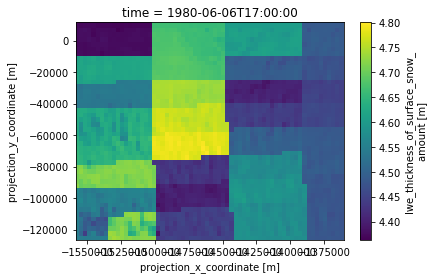

In [171]:
ds[var][-1,:,:].plot()

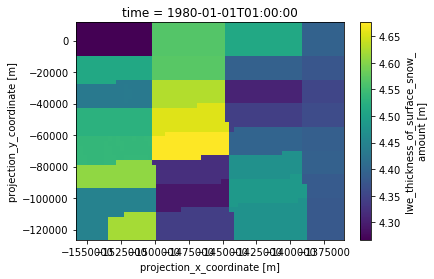

In [172]:
ds[var][0,:,:].plot()

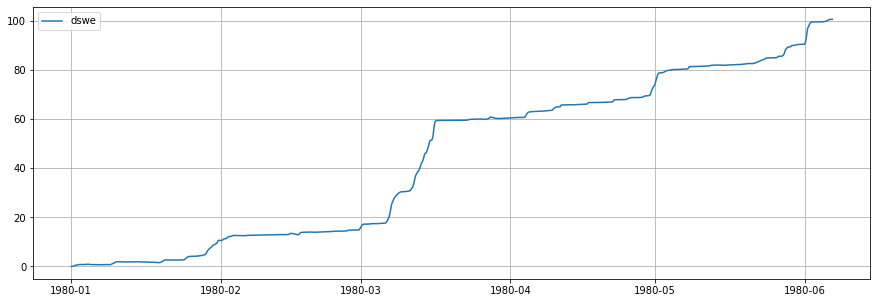

In [173]:
dm = ds['swe'] - ds['swe'].isel(time=0)

mean_dswe = dm.mean(dim='easting').mean(dim='northing') * 1000
mean_pr_cumsum = ds['pr'].mean(dim='easting').mean(dim='northing').cumsum()
mean_ET_cumsum = ds['ET'].mean(dim='easting').mean(dim='northing').cumsum()
mean_WE_cumsum = ds['WINDEROSIONDEPOSITION'].mean(dim='easting').mean(dim='northing').cumsum()
mean_RU_cumsum = ds['MS_SNOWPACK_RUNOFF'].mean(dim='easting').mean(dim='northing').cumsum()
mb = mean_pr_cumsum + mean_WE_cumsum - mean_ET_cumsum - mean_RU_cumsum

plt.figure(figsize=(15, 5))
plt.plot(ds['time'], mean_dswe, label='dswe')
# plt.plot(ds['time'],mean_pr_cumsum, label='precip')
# plt.plot(ds['time'],mb, label='Mass Balance Components')

plt.grid()
plt.legend()

# Compare delta SWE to sum of mass balance components. Units of mm water equivalent

Max Delta SWE (mm) = 129.52661
Mean Delta SWE (mm) = 100.59863
Min Delta SWE (mm) = -10.340214


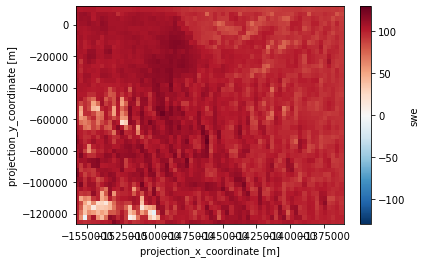

In [174]:
# Delta SWE
dswe = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
dswe = dswe * 1000 # Convert from m to mm water equivalent
dswe.plot()
dswe_mean = dswe.mean(dim='easting').mean(dim='northing').values
dswe_max = dswe.max().values
dswe_min = dswe.min().values

print("Max Delta SWE (mm) = " + str(dswe_max))
print("Mean Delta SWE (mm) = " + str(dswe_mean))
print("Min Delta SWE (mm) = " + str(dswe_min))

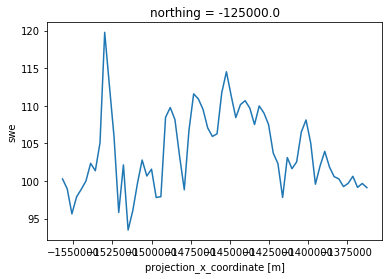

In [175]:
dswe[0,:].plot()

In [176]:
# Function to calculate timesum of variable
def time_sum(ds, var):
    time_sum = ds[var][dict(time=slice(1,len(ds['time'])))].sum(dim='time')
    return time_sum

# Function to calculate SMB from mass balance components
def calc_mb(ds):
    mb = time_sum(ds, 'MS_HNW') - time_sum(ds, 'ET') - time_sum(ds, 'MS_WIND') + time_sum(ds, 'MS_SNOWPACK_RUNOFF')
    return mb

Mean SMB (mm) = 100.59834
Mean ratio between Mass balance and delta SWE = 0.99999714


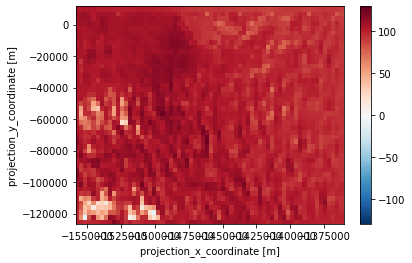

In [177]:
# Sum of mass balance components (note that only precipitation and sublimation are currently non-zero)
mb = calc_mb(ds)
mb.plot()
mb_mean = mb.mean(dim='easting').mean(dim='northing').values

print("Mean SMB (mm) = " + str(mb_mean))
print("Mean ratio between Mass balance and delta SWE = " + str(mb_mean / dswe_mean))

<xarray.DataArray ()>
array(-0.0002907, dtype=float32)


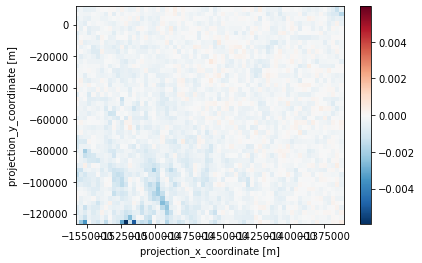

In [178]:
diff = mb - dswe
diff.plot()
print(diff.mean())

# Time sum drifting snow transport (mm)

<xarray.DataArray 'WINDEROSIONDEPOSITION' ()>
array(1.2947006, dtype=float32)


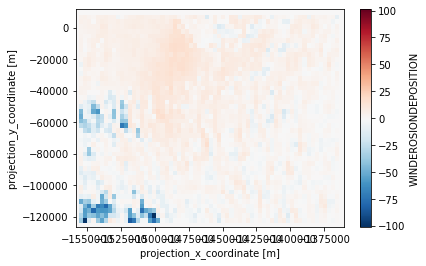

In [179]:
net_we = ds['WINDEROSIONDEPOSITION'].sum(dim='time')
net_we.plot()
print(net_we.mean())

# Drifting snow frequency

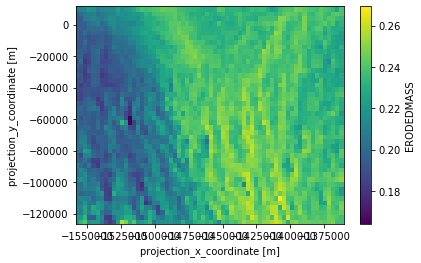

In [180]:
# True when drifting snow is occuring
erosion = ds['ERODEDMASS'] > 0

# Count number of True elements
erosion_frequency = erosion.sum(dim='time') / len(ds['time'])
erosion_frequency.plot()

# Close dataset so it can be opened again without restarting the kernel

In [181]:
ds.close()